In [165]:
# ## Steps
# - Initialize weights randomly
#     - Uniform Distribution Instantiation
#     - Xavier Instantiation
# - Give the model input and targets char pairs 
# - Forward pass 
#     - Calculate the probability for every possible 
#           next char according to the state of the model
# - Measure error
#     - Multi-Class Deviance
#     - Support 
# - Backpropagation Through Time
# - Update all parameters 
#     - Adagrad
#     - AdaDelta
# - Repeat Until Converged or Stops Improving
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [166]:
#Load Data
data = open('kafka.txt','r').read()

#Remove `\n` & tokenize by ' '
data = data.replace('\n',' ')
total_word_count = len(data.split())
word_basis = list(set(data.split()))
word_count = len(word_basis)

#Convert data into list of strings
data = data.split()

print('Total Number of Words: %s' % (total_word_count))
print('Number of Unique Words: %s' % (len(word_base)))

Total Number of Words: 25061
Number of Unique Words: 4565


In [167]:
#Mapping Dictionaries
word_to_ix = {word:i for i,word in enumerate(word_basis)}
ix_to_word = {i:word for i,word in enumerate(word_basis)}

#print word_to_ix
#print ix_to_word

# vector_for_word_a = np.zeros((word_count,1))
# vector_for_word_a[word_to_ix['ever']]=1
# print word_to_ix['ever']
# print vector_for_word_a.ravel()[101]

In [168]:
#Model Parameters
h1_size = 200
h2_size = 200
seq_len = 6

#Hyperparameter
learning_rate = 1e-1

In [169]:
#Weight and Bias Initialization

#Uniform Distribution
Wxh = np.random.randn(h1_size,word_count)*0.01
Whh = np.random.randn(h1_size, h2_size) * 0.01 #input to hidden
Why = np.random.randn(word_count, h2_size) * 0.01 #input to hidden
bh = np.zeros((h1_size, 1))
by = np.zeros((word_count, 1))

In [170]:
def lossFun(inputs,targets,hprev):
    xs, hs, ys, ps, = {}, {}, {}, {} #Empty dicts
    hs[-1] = np.copy(hprev)
    
    loss = 0
    
    #forward pass
    for t in xrange(len(inputs)):
        xs[t] = np.zeros((word_count,1)) # encode in 1-of-k representation (we place a 0 vector as the t-th input)                                                                                                                     
        xs[t][inputs[t]] = 1 # Inside that t-th input we use the integer in "inputs" list to  set the correct
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state                                                                                                            
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars                                                                                                           
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars                                                                                                              
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)                                                                                                                       
    
    #backward pass
    #initialize vectors for gradient values of weights
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    
    for t in reversed(xrange(len(inputs))):
        #output probabilities
        dy = np.copy(ps[t])
        
        #derive our first gradient
        dy[targets[t]] -= 1 # backprop into y  
        
        #Compute output gradient -  output times hidden states transpose
        #  When we apply the transpose weight matrix,  
        #  we can think intuitively of this as moving the error backward
        #  through the network, giving us some sort of measure of the error 
        #  at the output of the lth layer. 
        
        #output gradient
        dWhy += np.dot(dy, hs[t].T)
        
        #derivative of output bias
        dby += dy
        
        #backpropagate!
        dh = np.dot(Why.T, dy) + dhnext # backprop into h                                                                                                                                         
        
        # backprop through tanh nonlinearity 
        #     - revisit activation function in future
        dhraw = (1 - hs[t] * hs[t]) * dh 
        dbh += dhraw #derivative of hidden bias
        dWxh += np.dot(dhraw, xs[t].T) #derivative of input to hidden layer weight
        dWhh += np.dot(dhraw, hs[t-1].T) #derivative of hidden layer to hidden layer weight
        dhnext = np.dot(Whh.T, dhraw) 

    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients                                                                                                                 
    
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]
    

In [171]:
#prediction, one full forward pass
def sample(h, seed_ix, n):
    """                                                                                                                                                                                         
    sample a sequence of integers from the model                                                                                                                                                
    h is memory state, seed_ix is seed letter for first time step   
    n is how many characters to predict
    """
    #create vector
    x = np.zeros((word_count, 1))
    
    #customize it for our seed char
    x[seed_ix] = 1
    
    #list to store generated chars
    ixes = []
    
    #for as many words as we want to generate
    for t in xrange(n):
        #A hidden state at a given time step is a function 
        #  of (1) the input at the same time step modified by a weight matrix 
        #  added to (2) the hidden state of the previous time step 
        #  multiplied by its own hidden state to hidden state matrix.
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        
        #compute output (unnormalised)
        y = np.dot(Why, h) + by
        
        ## probabilities for next chars
        p = np.exp(y) / np.sum(np.exp(y))
        
        #pick one with the highest probability (not exactly)
        #--This implementation is not strictly mathematically correct
        #--it allows for random sampling using the probability distribution
        #--specified by p. If stochastic sampling is meant to be used
        #--as perturbation to prevent overfitting in training, then it is correct.
        ix = np.argmax(p.ravel())
        
        #create a vector
        x = np.zeros((word_count, 1))
        
        #customize it for the predicted word
        x[ix] = 1
        
        #add it to the list
        ixes.append(ix)

    txt = [ix_to_word[ix] for ix in ixes]
    print '----\n %s \n----' % (txt, )
    
# reset RNN memory 
hprev = np.zeros((h2_size,1)) 

#predict the next word given 'ever'
sample(hprev,word_to_ix['ever'],4)

----
 ['"What', 'outstretched,', 'here!', 'drawers.'] 
----


In [172]:
#ModelTraining

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad                                                                                                                
smooth_loss = -np.log(1.0/word_count)*seq_len # loss at iteration 0  

track_loss = []
track_iter = []

while n<=1000*100:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    # check "How to feed the loss function to see how this part works
    if p+seq_len+1 >= len(data) or n == 0:
        hprev = np.zeros((h2_size,1)) # reset RNN memory                                                                                                                                      
        p = 0 # go from start of data  
    
    # Train on [p:p+seq_len]
    # Test on [p+1:p+seq_len+1]
    #Predictions are offset from training by 1 word (last target word not in input)
    inputs = [word_to_ix[word] for word in data[p:p+seq_len]]
    targets = [word_to_ix[word] for word in data[p+1:p+seq_len+1]]

    # forward seq_length characters through the net 
    # and fetch gradient                                                                                                                          
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001

    #store training progress - MIKEY
    track_loss.append(loss)
    track_iter.append(n)
    
    # sample from the model now and then                                                                                                                                                        
    if n % 1000 == 0:
        print 'iter %d, loss: %f' % (n, smooth_loss) # print progress
        sample(hprev, inputs[0], seq_len)

    # Perform parameter update with Adagrad  -- VERY IMPORTANT                                                                                                                                                   
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                [dWxh, dWhh, dWhy, dbh, dby],
                                [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        
        #AdaGrad Update
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) 

    p += seq_len # move data pointer                                                                                                                                                         
    n += 1 # iteration counter    

iter 0, loss: 50.557043
----
 ['royalties.', 'current', 'can.', 'at', 'demand', 'been.'] 
----
iter 1000, loss: 75.951483
----
 ['the', 'sister', 'the', 'sister', 'the', 'sister'] 
----
iter 2000, loss: 69.143843
----
 ['the', 'opposite;', 'the', 'opposite;', 'the', 'opposite;'] 
----
iter 3000, loss: 62.644976
----
 ['in', 'movement;', 'in', 'movement;', 'in', 'movement;'] 
----
iter 4000, loss: 63.236665
----
 ['discover', 'a', 'discover', 'a', 'discover', 'a'] 
----
iter 5000, loss: 52.827167
----
 ['chief', 'sounded', 'chief', 'the', 'chief', 'sounded'] 
----
iter 6000, loss: 46.177927
----
 ['the', 'the', 'the', 'he', 'had', 'the'] 
----
iter 7000, loss: 43.678610
----
 ['the', 'learned', 'of', 'learned', 'the', 'learned'] 
----
iter 8000, loss: 43.621594
----
 ['of', 'the', 'Project', 'The', 'Project', 'The'] 
----
iter 9000, loss: 42.511480
----
 ['the', 'train,', "o'clock", 'train,', 'the', 'train,'] 
----
iter 10000, loss: 40.721739
----
 ['the', 'the', 'state,', 'of', 'the', 

iter 94000, loss: 21.206807
----
 ['it', 'so', 'that', 'Gregor', 'was', 'not'] 
----
iter 95000, loss: 21.166638
----
 ['sister', 'had', 'been', 'in', 'any', 'room'] 
----
iter 96000, loss: 19.516074
----
 ['works', 'of', 'the', 'United', 'States.', 'Compliance'] 
----
iter 97000, loss: 20.218443
----
 ['and', 'he', 'had', 'been', 'occupied', 'with'] 
----
iter 98000, loss: 20.535725
----
 ['to', 'see', 'it', 'even', 'a', 'great'] 
----
iter 99000, loss: 20.697165
----
 ['the', 'kitchen,', 'as', 'he', 'had', 'been'] 
----
iter 100000, loss: 19.435227
----
 ['comply', 'with', 'the', 'other', 'terms', 'of'] 
----


In [182]:
#print data[100:100+seq_len]

a=[word_to_ix[word] for word in data[30:30+seq_len+10]]
#print a
sample(hprev, a, seq_len+10)

----
 ['require', 'at', 'the', 'other', 'of', 'the', 'Project', 'Gutenberg-tm', 'works.', '1.E.9.', 'If', 'you', 'may', 'paid', 'at', 'any'] 
----


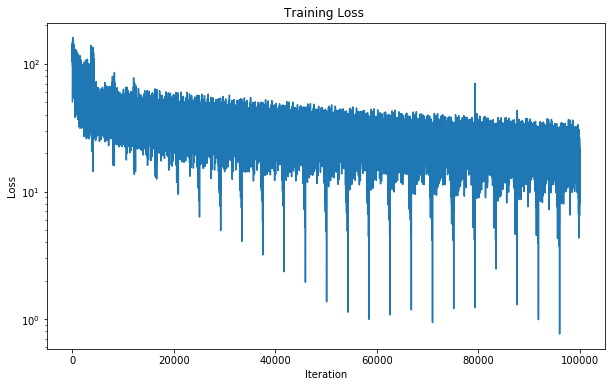

In [183]:
plt.figure(figsize=(10,6))
plt.plot(track_iter,track_loss)
plt.yscale('log')
plt.title('Training Loss ')
plt.xlabel('Iteration')
plt.ylabel('Loss')